<a href="https://colab.research.google.com/github/sanghun1210/mlworkshop/blob/main/stock/stock_predict_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U numpy
!pip install finance-datareader
import FinanceDataReader as fdr

def get_stock_list():
    try:
        df_krx = fdr.StockListing("KRX")
        return df_krx
    except Exception as e:    
        print("raise error ", e)
    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_krx = get_stock_list()
sam_df = fdr.DataReader(df_krx['Code'][0])
sam_df.head()




,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-02-19,1663,1663,1602,1653,503847,NaN
1999-02-22,1624,1624,1583,1605,390357,-0.029038
1999-02-23,1616,1624,1538,1595,489420,-0.006231
1999-02-24,1586,1637,1579,1605,450797,0.006270
1999-02-25,1584,1667,1577,1644,428566,0.024299


<Axes: ylabel='Frequency'>

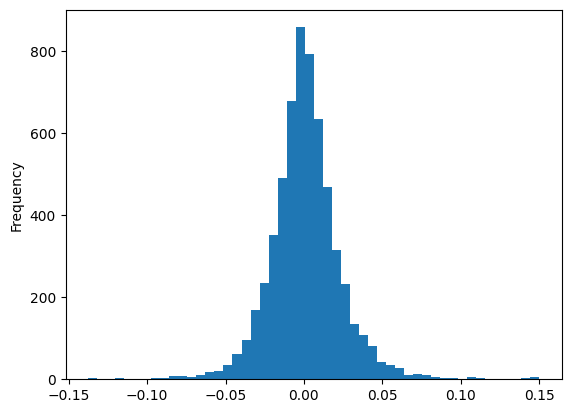

In [ ]:
sam_df['Change'].plot.hist(bins=50)
# plt.xlabel("Adjusted close 1 day percent change")
# plt.show()

#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26, random_state=0)

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4415    0  4415    0     0  25228      0 --:--:-- --:--:-- --:--:-- 25228
100  517k  100  517k    0     0  1138k      0 --:--:-- --:--:-- --:--:-- 2012k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4367    0  4367    0     0  27293      0 --:--:-- --:--:-- --:--:-- 27293
100  392k  100  392k    0     0  1004k      0 --:--:-- --:--:-- --:--:-- 1004k


In [ ]:
import talib
import numpy as np

print(sam_df['Close'].values)
feature_names = []

float_data = [float(x) for x in sam_df['Close']]
np_float_data = np.array(float_data)
for n in [14, 30, 50, 200]:
    sam_df['ma' + str(n)] = talib.SMA(np_float_data, timeperiod=n)
    sam_df['rsi' + str(n)] = talib.RSI(np_float_data, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

sam_df['Volume_1d_change'] = sam_df['Volume'].pct_change()

volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)
print(feature_names)



[ 1653  1605  1595 ... 71400 70900 72200]
['ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200', 'Volume_1d_change']


In [ ]:

sam_df['5d_future_close'] = sam_df['Close'].shift(-5)
sam_df['5d_close_future_pct'] = sam_df['5d_future_close'].pct_change(5)

In [24]:
sam_df.dropna(inplace=True)
sam_df = sam_df[np.isfinite(sam_df).all(1)]

X = sam_df[feature_names]
y = sam_df['5d_close_future_pct']

print(y.shape, y.shape[0])
train_size = int(0.85 * y.shape[0])
print(train_size)
X_train = X[:train_size].to_numpy()
y_train = y[:train_size].to_numpy()
X_test = X[train_size:].to_numpy()
y_test = y[train_size:].to_numpy()



(5792,) 5792
4923


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid

grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()

print(len(X_train))
print(len(X_test))

#X_train.dropna()
#X_train_new = X_train[np.isfinite(X_train).all(1)]

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

4923
869
-0.18366912925730539 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


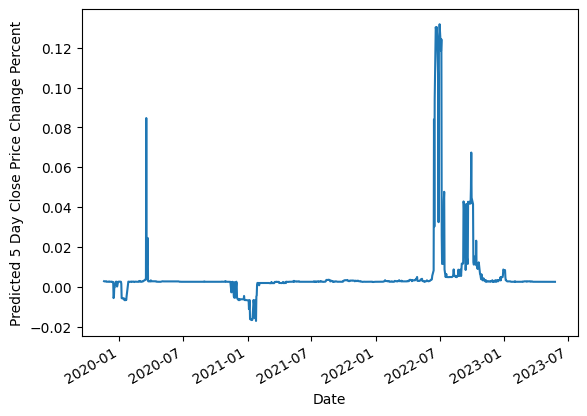

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y[train_size:].index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()